In [38]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize

In [39]:
tickers = ['NVDA','AAPL','MSFT','AMD', 'GOOGL', 'AMZN', 'TSLA', 'MU']
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

In [40]:
# Robust multi-ticker download with adjusted prices and MultiIndex handling
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,           # adjusted already lives in 'Close'
    group_by="column",
    progress=False
)

# Extract adjusted price level for both old/new yfinance behaviors
if isinstance(raw.columns, pd.MultiIndex):
    lvl0 = raw.columns.get_level_values(0)
    want = "Adj Close" if "Adj Close" in lvl0 else "Close"
    adj_close_df = raw.xs(want, axis=1, level=0)
else:
    want = "Adj Close" if "Adj Close" in raw.columns else "Close"
    adj_close_df = raw[[want]]
    # If a single ticker was provided, rename the column to the ticker symbol
    if isinstance(tickers, list) and len(tickers) == 1:
        adj_close_df = adj_close_df.rename(columns={want: tickers[0]})

# Optional: align to business days and fill small gaps
adj_close_df = (
    adj_close_df.sort_index()
                .asfreq("B")
                .ffill(limit=3)
                .dropna(how="all")
)

print(f"Adjusted close DataFrame shape: {adj_close_df.shape}")
print(f"Columns in adj_close_df: {list(adj_close_df.columns)}")
if not adj_close_df.empty:
    print(f"Date range: {adj_close_df.index[0]} to {adj_close_df.index[-1]}")
    print(adj_close_df.head())
else:
    print("Error: No data was downloaded. Check tickers/date range/network.")

Adjusted close DataFrame shape: (1305, 8)
Columns in adj_close_df: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'TSLA']
Date range: 2020-08-10 00:00:00 to 2025-08-08 00:00:00
Ticker            AAPL        AMD        AMZN      GOOGL        MSFT  \
Date                                                                   
2020-08-10  109.776482  82.239998  157.408005  74.394836  199.521332   
2020-08-11  106.511757  76.879997  154.033493  73.585686  194.855423   
2020-08-12  110.051590  82.610001  158.112000  74.912720  200.421936   
2020-08-13  111.999237  81.839996  158.050995  75.380417  199.952499   
2020-08-14  111.899414  81.300003  157.401001  74.783005  200.144104   

Ticker             MU       NVDA        TSLA  
Date                                          
2020-08-10  48.004917  11.128321   94.571335  
2020-08-11  46.647301  10.814353   91.625999  
2020-08-12  47.350529  11.402665  103.650665  
2020-08-13  45.065041  11.405406  108.066666  
2020-08-14  44.537632  11.52

In [41]:
from typing import Any

class Console:
    @staticmethod
    def log(*args: Any) -> None:
        print(*args)

console = Console()
console.log("Code is", "Poetry")

Code is Poetry


In [42]:
# Compute log returns using diff of logs (fast & stable)
if adj_close_df.empty:
    print("Error: adj_close_df is empty; cannot compute log returns.")
else:
    log_returns = np.log(adj_close_df).diff().dropna(how="all")
    print(f"Log returns shape: {log_returns.shape}")
    if not log_returns.empty:
        print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")
        print("First few log returns:\n", log_returns.head())
    else:
        print("Warning: Log returns DataFrame is empty after diff/dropna.")

Log returns shape: (1304, 8)
Date range: 2020-08-11 00:00:00 to 2025-08-08 00:00:00
First few log returns:
 Ticker          AAPL       AMD      AMZN     GOOGL      MSFT        MU  \
Date                                                                     
2020-08-11 -0.030191 -0.067396 -0.021671 -0.010936 -0.023663 -0.028688   
2020-08-12  0.032694  0.071885  0.026134  0.017873  0.028167  0.014963   
2020-08-13  0.017543 -0.009365 -0.000386  0.006224 -0.002345 -0.049471   
2020-08-14 -0.000892 -0.006620 -0.004121 -0.007957  0.000958 -0.011772   
2020-08-17 -0.002614  0.013682  0.010865  0.007686  0.006584 -0.008368   

Ticker          NVDA      TSLA  
Date                            
2020-08-11 -0.028619 -0.031639  
2020-08-12  0.052973  0.123311  
2020-08-13  0.000240  0.041722  
2020-08-14  0.010519  0.018162  
2020-08-17  0.064706  0.106188  


In [43]:
# Annualized covariance matrix from log returns
try:
    if 'log_returns' not in globals() or log_returns.empty:
        print("Error: log_returns is not available or empty; compute it first.")
    else:
        cov_matrix = log_returns.cov() * 252
        print("Covariance matrix shape:", cov_matrix.shape)
        print("Tickers:", list(cov_matrix.columns))
        print("\nHead of covariance matrix:\n", cov_matrix.head())
except NameError:
    print("Error: log_returns not defined; run the log-returns cell first.")

Covariance matrix shape: (8, 8)
Tickers: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'TSLA']

Head of covariance matrix:
 Ticker      AAPL       AMD      AMZN     GOOGL      MSFT        MU      NVDA  \
Ticker                                                                         
AAPL    0.083151  0.077028  0.059383  0.051274  0.049501  0.055831  0.080883   
AMD     0.077028  0.245741  0.093770  0.080874  0.074076  0.131767  0.187160   
AMZN    0.059383  0.093770  0.121082  0.068309  0.062308  0.070140  0.103662   
GOOGL   0.051274  0.080874  0.068309  0.092716  0.054245  0.059787  0.085865   
MSFT    0.049501  0.074076  0.062308  0.054245  0.067888  0.053399  0.086509   

Ticker      TSLA  
Ticker            
AAPL    0.091342  
AMD     0.144800  
AMZN    0.096393  
GOOGL   0.075832  
MSFT    0.069991  


In [44]:
# Portfolio performance metrics
import numpy as np

def standard_deviation(weights, cov_matrix):
    w = np.asarray(weights)
    return np.sqrt(w.T @ cov_matrix @ w)

def expected_return(weights, log_returns):
    w = np.asarray(weights)
    return np.sum(log_returns.mean().values * w) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate=0.0):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [45]:
# Portfolio optimization (maximize Sharpe)
from scipy.optimize import minimize

risk_free_rate = 0.02  # 2%


def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

n_assets = len(adj_close_df.columns)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
bounds = tuple((0.0, 0.4) for _ in range(n_assets))
initial_weights = np.array([1.0 / n_assets] * n_assets)

if 'log_returns' in globals() and not log_returns.empty:
    optimized_results = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(log_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
    )
    print("Optimization success:", optimized_results.success)
    if not optimized_results.success:
        print("Message:", optimized_results.message)
else:
    print("Error: compute log_returns and cov_matrix before optimization.")

Optimization success: True


Optimal Weights:
AAPL: 0.0000
AMD: 0.0000
AMZN: 0.0000
GOOGL: 0.2058
MSFT: 0.3942
MU: 0.0000
NVDA: 0.4000
TSLA: 0.0000

Expected Annual Return: 0.3292
Expected Volatility: 0.3273
Sharpe Ratio: 0.9448


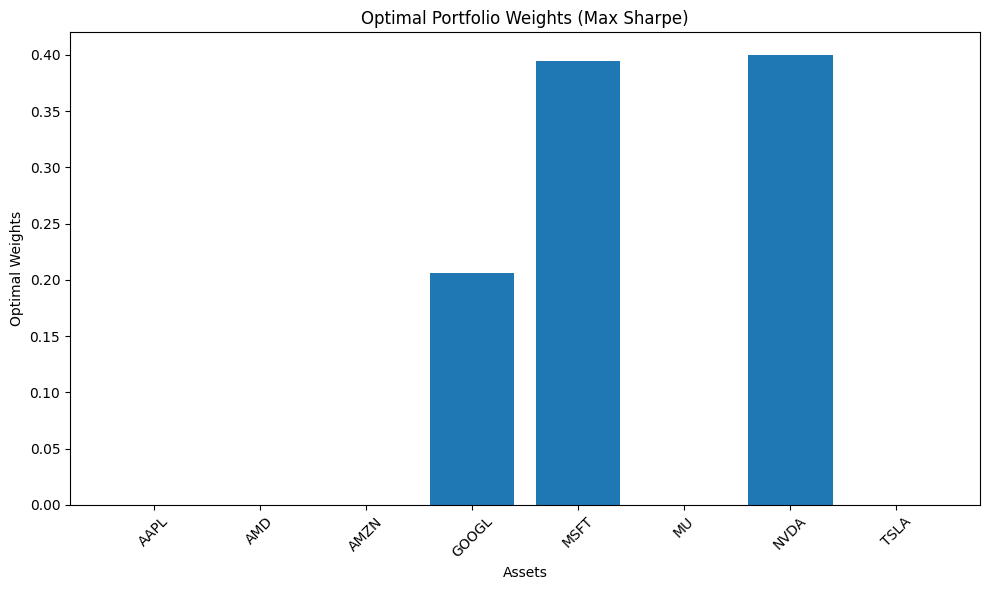

In [46]:
# Analyze the optimal portfolio and plot weights
import matplotlib.pyplot as plt

try:
    optimal_weights = optimized_results.x
    print("Optimal Weights:")
    for t, w in zip(adj_close_df.columns, optimal_weights):
        print(f"{t}: {w:.4f}")

    opt_ret = expected_return(optimal_weights, log_returns)
    opt_vol = standard_deviation(optimal_weights, cov_matrix)
    opt_sr = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

    print(f"\nExpected Annual Return: {opt_ret:.4f}")
    print(f"Expected Volatility: {opt_vol:.4f}")
    print(f"Sharpe Ratio: {opt_sr:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(adj_close_df.columns, optimal_weights)
    plt.xlabel('Assets')
    plt.ylabel('Optimal Weights')
    plt.title('Optimal Portfolio Weights (Max Sharpe)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Optimization results not available:", str(e))

In [47]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")
log = logging.getLogger("console")

log.info("Code is Poetry")

2025-08-09 19:19:24,947 INFO: Code is Poetry
